# Loading necessary libraries

In [1]:
# Clear memory
%reset -f

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')


In [2]:
# System imports
import sys
import importlib
from pathlib import Path

# Visualization imports
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
plt.style.use('ggplot')

# Project setup
project_root = Path().resolve().parent
sys.path.append(str(project_root))

# Project modules
MODULES = [
    'iowa_dream.data',
    'iowa_dream.data.importer',
    'iowa_dream.data.loader', 
    'iowa_dream.utils.plotting_EDA',
    'iowa_dream.utils.describer',
    'iowa_dream.data.cleaner',
    'iowa_dream.utils.inconsistency_check'
]

# Reload modules
for module in MODULES:
    if module in sys.modules:
        importlib.reload(sys.modules[module])
    else:
        __import__(module)

# Project imports
from iowa_dream.data.importer import load_config
from iowa_dream.data.loader import preliminary_loader
from iowa_dream.utils.describer import (
    categorical_describer,
    numerical_describer, 
    analyze_categorical_sparsity
)
from iowa_dream.utils.plotting_EDA import (
    plot_missing_data_heatmap,
    box_plot_dist,
    target_distribution_plotting,
    plot_target_over_time,
    plot_feature_distributions_interactive,
    plot_feature_target_relationships_interactive,
    plot_price_vs_sale_condition,
    plot_cramer_v_associations,
    anova_categorical_feature_importance,
    plot_numerical_correlation_matrix,
    plot_feature_histograms
)
from iowa_dream.data.cleaner import (
    simple_fill_missing_by_keywords,
    garage_imputer,
    type_formatting
)
from iowa_dream.utils.inconsistency_check import (
    report_inconsistent_years,
    consistency_missing_type_area
)

# 0. Preliminary Load the Cleaned Data

In [3]:
# Example usage
data_file = project_root / load_config()['kaggle']['download_path'] / 'AmesHousing.csv'
# In this loader, we have standardized column names by replacing spaces with underscores, 
# converting to lowercase, 
# and applying specific replacements such as 'yr' to 'year', 
# 'qual' or 'qc' to 'qu' (quality), 
# 'abvgrd' to 'abvgr' (above grade), and 
# 'built' to 'blt' (built).
df_original = preliminary_loader(data_file)

In [4]:
# Extract feature column names for different data types
data_dict = load_config()['data_dict']
ordinal = data_dict['ordinal_columns']['columns']
nominal = data_dict['nominal_columns']['columns'] 
continuous = data_dict['continuous_columns']['columns']
discrete = data_dict['discrete_columns']['columns']
ordinal_mappings = load_config()['ordinal_mappings']

#1. Some EDAs on the Target of `saleprice`

In [5]:
df = df_original.copy()

In [6]:
numerical_describer(df, ['saleprice'])


Numerical Columns Summary:
Total numerical columns: 1
Columns with missing values: 0


,Total Missing,Percent Missing,Data Type,Value Information,Mean,Std Dev,Min,25%,50%,75%,Max
saleprice,0,0.0,int64,Range: 12789 to 755000 (1032 unique values),180796.060068,79886.692357,12789,129500.0,160000.0,213500.0,755000


Comment: No missing values but seems to disperse a lot. 


Price Range Distribution (%):
saleprice
<$100k          8.6
$100k-$200k    62.2
$200k-$300k    21.4
$300k-$400k     5.7
>$400k          2.2

Normality Tests (α = 0.1):
              Test  Test Statistic       p-value    Result
D'Agostino-Pearson     1074.646596 4.400040e-234 Reject H₀
      Shapiro-Wilk        0.876261  2.334909e-43 Reject H₀
  Anderson-Darling       87.367435           NaN Reject H₀
       Jarque-Bera     4668.421409  0.000000e+00 Reject H₀

Fat-Tailed Tests (α = 0.1):
    Test  Test Statistic  Reference Value     Result
Kurtosis        8.108122              3.0 Fat-tailed


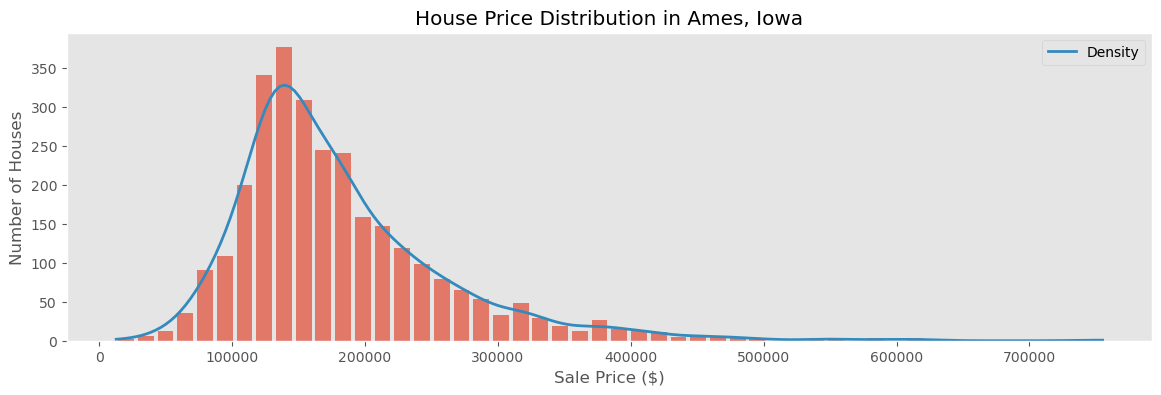

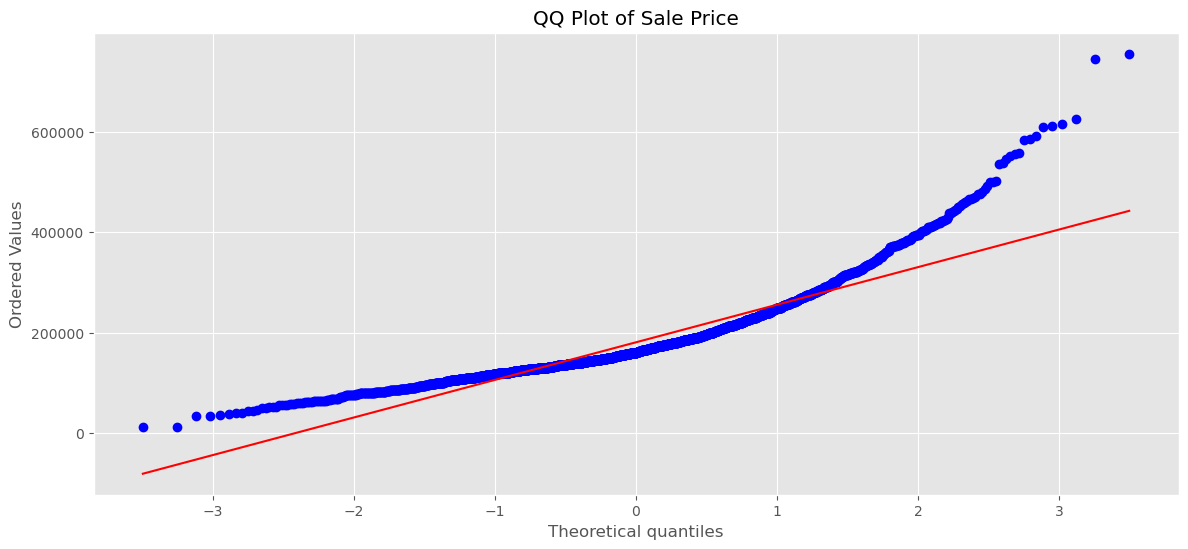

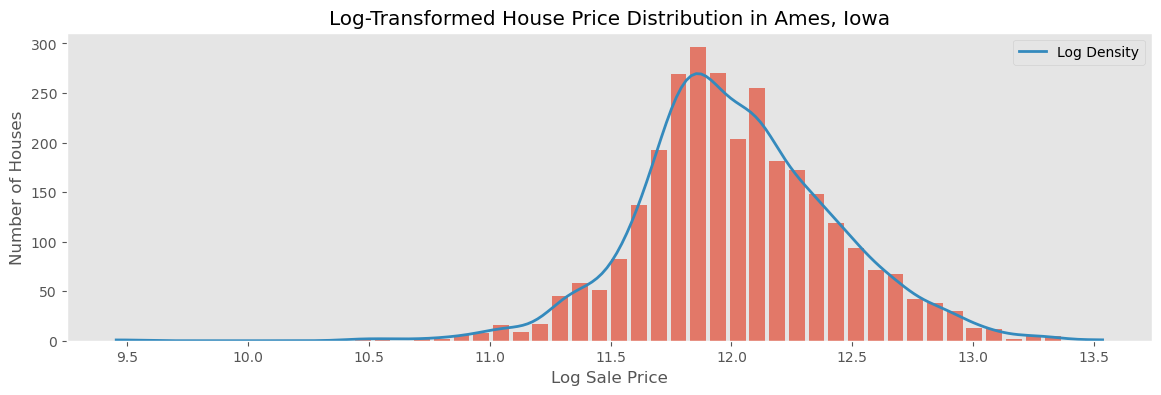

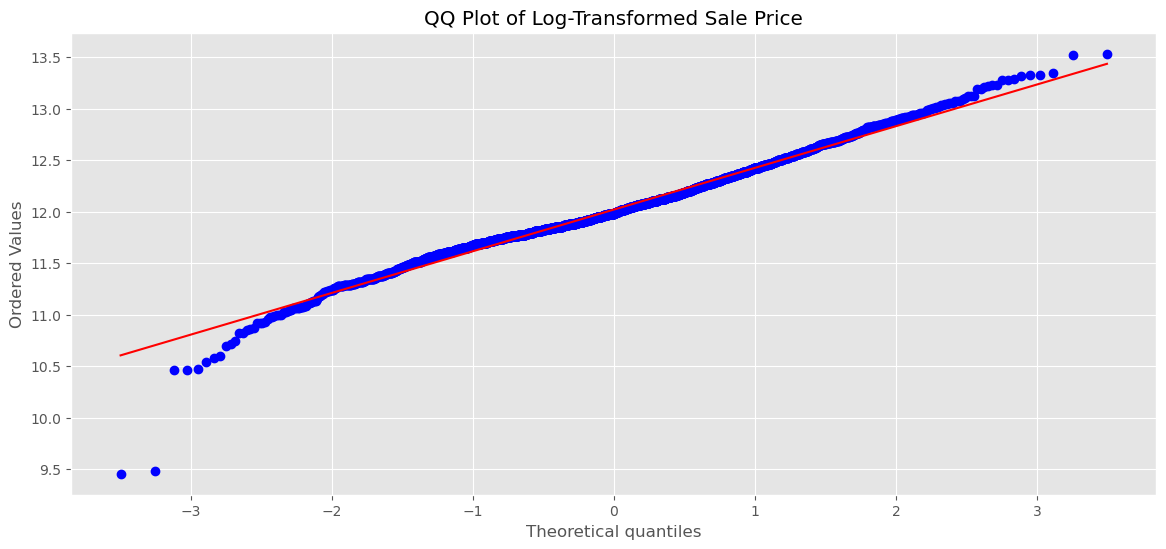

In [7]:
target_distribution_plotting(df, target_col='saleprice')

Comment: Overall, the distribution seems to be skewed and have fat-failed. Furthermore, there are some values that are extreme outliers, beyond 500,000 for example. After taking logs, the distribution still seems roughly normal (symmetric) though with longer left tails. In fitting GLM, we may consider using a gamma distribution for the target variable, with log-links to capture this feature.

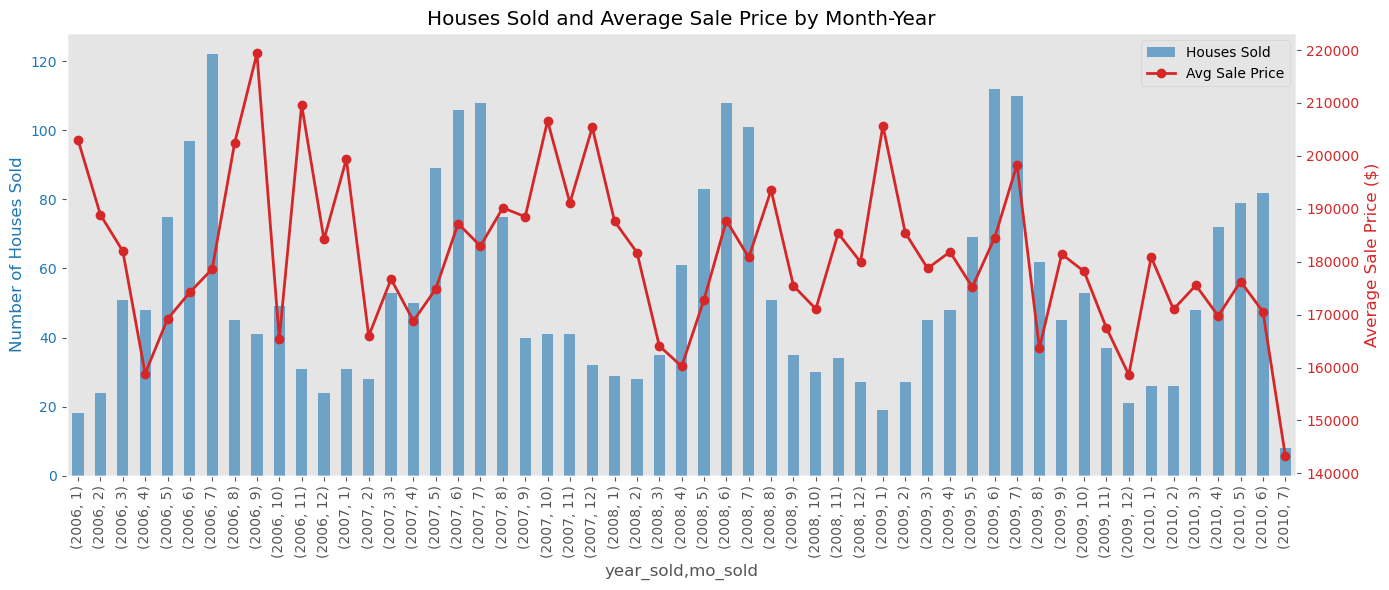

In [8]:
# Plot the number of houses sold and average sale price over time to analyze trends
# Shows both volume of sales and price changes month by month
plot_target_over_time(df, target_col='saleprice', year_col='year_sold', month_col='mo_sold')

Comment: Interesting to see some seasonal patterns. The number of houses sold is highest in the summer months and the average sale price tends to higher in the second half of the year. Motivating combining year_sold and mo_sold into a single feature.


### Outliers

"There are 5 observations that an instructor may wish to remove from the data set before giving it to students (a plot of SALE PRICE versus GR LIV AREA will indicate them quickly). Three of them are true outliers (Partial Sales that likely don’t represent actual market values) and two of them are simply unusual sales (very large houses priced relatively appropriately)." - Author of the dataset

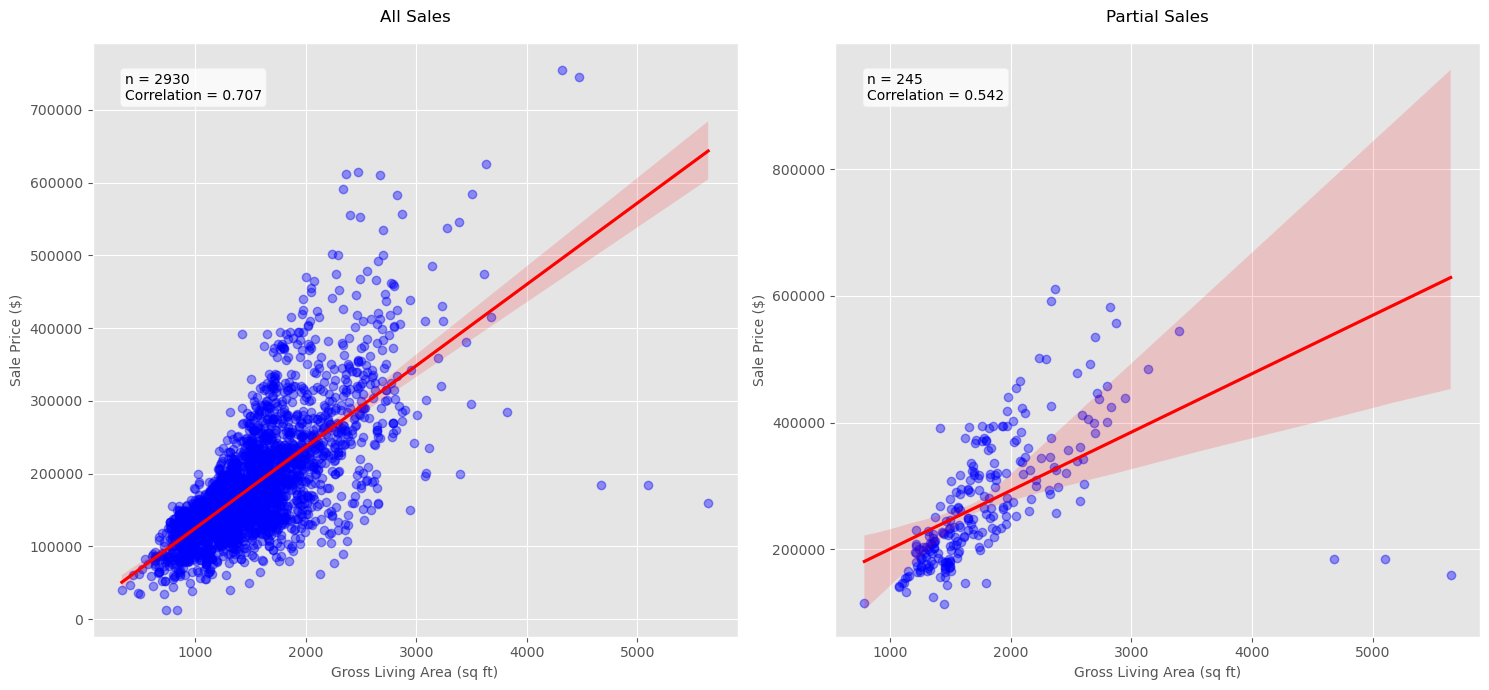

In [9]:
# Example usage:
plot_price_vs_sale_condition(df, sale_conditions=['Partial'])

Comment: We will drop the three observations that are true outliers where it does not represent actual market values and excessive high sales.

In [10]:
# Filter out the outliers where gr_liv_area > 4000 and saleprice < 200000
df = df[~((df.gr_liv_area > 4000))]

#2. Feature Description

In [11]:
categorical_describer(df, nominal)


Categorical Columns Summary:
Total categorical columns: 28
Columns with missing values: 5


,Total Missing,Percent Missing,Data Type,Value Information,Mode,Mode Frequency
misc_feature,2820,0.964103,object,"4 unique values: Gar2, Othr, Shed, TenC",Shed,95
alley,2727,0.932308,object,"2 unique values: Grvl, Pave",Grvl,120
mas_vnr_type,1774,0.606496,object,"4 unique values: BrkCmn, BrkFace, CBlock, Stone",BrkFace,879
garage_year_blt,159,0.054359,float64,"103 unique values: 1895.0, 1896.0, 1900.0, 190...",2005.0,142
garage_type,157,0.053675,object,"6 unique values: 2Types, Attchd, Basment, Buil...",Attchd,1727
ms_subclass,0,0.000000,int64,"16 unique values: 20, 30, 40, 45, 50, 60, 70, ...",20,1078
year_sold,0,0.000000,int64,"5 unique values: 2006, 2007, 2008, 2009, 2010",2007,690
year_remod/add,0,0.000000,int64,"61 unique values: 1950, 1951, 1952, 1953, 1954...",1950,361
year_blt,0,0.000000,int64,"118 unique values: 1872, 1875, 1879, 1880, 188...",2005,142
sale_condition,0,0.000000,object,"6 unique values: Abnorml, AdjLand, Alloca, Fam...",Normal,2412


Comment: `ms_subclass` should be reformatted to be a categorical variable because it indicates building class. We will take notes of this for **preprocessing**. We will consider dropping 'misc_feature' which captures a lot of irregular facilities like tennis court, shed, etc. In the dataset, `NA` indicates that there is no miscellaneous feature. Given that very few houses have such distinct features, we will consider dropping this feature (the same with alley access, as `NA` indicates no alley access).

In [12]:
categorical_describer(df, ordinal)


Categorical Columns Summary:
Total categorical columns: 23
Columns with missing values: 12


,Total Missing,Percent Missing,Data Type,Value Information,Mode,Mode Frequency
pool_qu,2914,0.996239,object,"4 unique values: Ex, Fa, Gd, TA",Ex,3
fence,2354,0.804786,object,"4 unique values: GdPrv, GdWo, MnPrv, MnWw",MnPrv,329
fireplace_qu,1422,0.486154,object,"5 unique values: Ex, Fa, Gd, Po, TA",Gd,741
garage_cond,159,0.054359,object,"5 unique values: Ex, Fa, Gd, Po, TA",TA,2660
garage_qu,159,0.054359,object,"5 unique values: Ex, Fa, Gd, Po, TA",TA,2610
garage_finish,159,0.054359,object,"3 unique values: Fin, RFn, Unf",Unf,1231
bsmt_exposure,83,0.028376,object,"4 unique values: Av, Gd, Mn, No",No,1906
bsmtfin_type_2,81,0.027692,object,"6 unique values: ALQ, BLQ, GLQ, LwQ, Rec, Unf",Unf,2494
bsmt_cond,80,0.027350,object,"5 unique values: Ex, Fa, Gd, Po, TA",TA,2611
bsmt_qu,80,0.027350,object,"5 unique values: Ex, Fa, Gd, Po, TA",TA,1283


The scale for quality and condition is: Ex - Excellent, Gd - Good, TA - Average/Typical, Fa - Fair, Po - Poor. Ordinal encoding can apply to this scale for `pool_qu`, `fireplace_qu`, `garage_cond`, `garage_qu`, `bsmt_cond`, `bsmt_qu`, `heating_qu`, `kitchen_qu`, `exter_cond`, `exter_qu`. Significant missing values exist for `pool`, `fireplace`, and `fence` quality (as from the data dictionary, it means there are no such facilities). We will then consider dropping `pool_qu` and `fence`.  

In [13]:
# Assert whether all pool_area values are 0 for missing pool_qu
assert (df[df['pool_qu'].isnull()]['pool_area'] == 0).all(), "Not all missing pool_qu have pool_area equal to 0"

In [14]:
numerical_describer(df, continuous)


Numerical Columns Summary:
Total numerical columns: 19
Columns with missing values: 7


,Total Missing,Percent Missing,Data Type,Value Information,Mean,Std Dev,Min,25%,50%,75%,Max
lot_frontage,490,0.167521,float64,Range: 21.0 to 313.0 (129 unique values),69.023819,22.710918,21.0,58.00,68.0,80.00,313.0
mas_vnr_area,23,0.007863,float64,Range: 0.0 to 1600.0 (443 unique values),100.710544,176.034290,0.0,0.00,0.0,164.00,1600.0
bsmtfin_sf_1,1,0.000342,float64,Range: 0.0 to 2288.0 (992 unique values),438.097469,438.032289,0.0,0.00,369.5,733.25,2288.0
bsmtfin_sf_2,1,0.000342,float64,Range: 0.0 to 1526.0 (275 unique values),49.807456,169.300590,0.0,0.00,0.0,0.00,1526.0
bsmt_unf_sf,1,0.000342,float64,Range: 0.0 to 2336.0 (1137 unique values),558.947332,439.621369,0.0,218.75,464.5,801.00,2336.0
total_bsmt_sf,1,0.000342,float64,Range: 0.0 to 3206.0 (1054 unique values),1046.852257,421.109533,0.0,792.75,989.5,1299.25,3206.0
garage_area,1,0.000342,float64,Range: 0.0 to 1488.0 (600 unique values),471.883721,213.816049,0.0,320.00,480.0,576.00,1488.0
open_porch_sf,0,0.000000,int64,Range: 0 to 742 (249 unique values),47.166838,66.571810,0.0,0.00,27.0,70.00,742.0
pool_area,0,0.000000,int64,Range: 0 to 800 (12 unique values),1.893333,32.964272,0.0,0.00,0.0,0.00,800.0
screen_porch,0,0.000000,int64,Range: 0 to 576 (121 unique values),16.029402,56.131397,0.0,0.00,0.0,0.00,576.0


Comment: Some features indicate a lot of large variations like `misc_val`, i.e. value of miscellaneous feature which makes sense give that it indicates quite a diverse range of thing: `Elev`: Elevator,`Gar2`: 2nd Garage (if not described in garage section), `Othr`: Other, `Shed`: Shed (over 100 SF), `TenC`: Tennis Court. Given that we drop `misc_feature`, we will also drop `misc_val`. 

In [15]:
numerical_describer(df, discrete)


Numerical Columns Summary:
Total numerical columns: 9
Columns with missing values: 3


,Total Missing,Percent Missing,Data Type,Value Information,Mean,Std Dev,Min,25%,50%,75%,Max
bsmt_full_bath,2,0.000684,float64,Range: 0.0 to 3.0 (5 unique values),0.430380,0.524089,0.0,0.0,0.0,1.0,3.0
bsmt_half_bath,2,0.000684,float64,Range: 0.0 to 2.0 (4 unique values),0.060554,0.244223,0.0,0.0,0.0,0.0,2.0
garage_cars,1,0.000342,float64,Range: 0.0 to 5.0 (7 unique values),1.765048,0.759834,0.0,1.0,2.0,2.0,5.0
full_bath,0,0.000000,int64,Range: 0 to 4 (5 unique values),1.564786,0.551386,0.0,1.0,2.0,2.0,4.0
half_bath,0,0.000000,int64,Range: 0 to 2 (3 unique values),0.378462,0.502403,0.0,0.0,0.0,1.0,2.0
bedroom_abvgr,0,0.000000,int64,Range: 0 to 8 (8 unique values),2.853675,0.827737,0.0,2.0,3.0,3.0,8.0
kitchen_abvgr,0,0.000000,int64,Range: 0 to 3 (4 unique values),1.044444,0.214251,0.0,1.0,1.0,1.0,3.0
totrms_abvgr,0,0.000000,int64,Range: 2 to 14 (13 unique values),6.434188,1.557887,2.0,5.0,6.0,7.0,14.0
fireplaces,0,0.000000,int64,Range: 0 to 4 (5 unique values),0.596923,0.645349,0.0,0.0,1.0,1.0,4.0


In [16]:
# Check if bsmt_full_bath and bsmt_half_bath missing values occur together
missing_baths = df[df['bsmt_full_bath'].isnull() | df['bsmt_half_bath'].isnull()]
bsmt_cols = [col for col in df.columns if 'bsmt' in col.lower()]
print("Observations with missing basement bath values:")
print(missing_baths[bsmt_cols])

Observations with missing basement bath values:
     bsmt_qu bsmt_cond bsmt_exposure bsmtfin_type_1  bsmtfin_sf_1  \
1341     NaN       NaN           NaN            NaN           NaN   
1497     NaN       NaN           NaN            NaN           0.0   

     bsmtfin_type_2  bsmtfin_sf_2  bsmt_unf_sf  total_bsmt_sf  bsmt_full_bath  \
1341            NaN           NaN          NaN            NaN             NaN   
1497            NaN           0.0          0.0            0.0             NaN   

      bsmt_half_bath  
1341             NaN  
1497             NaN  


After initial inspection, we will drop `misc_feature`, `misc_val`, `pool_qu`, `pool_area` `fence`, `alley` as they are very uncommon features.

In [17]:
df = df.drop(['misc_feature', 'misc_val', 'pool_qu', 'pool_area', 'fence', 'alley'], axis=1)

#3. Further on Missing Values

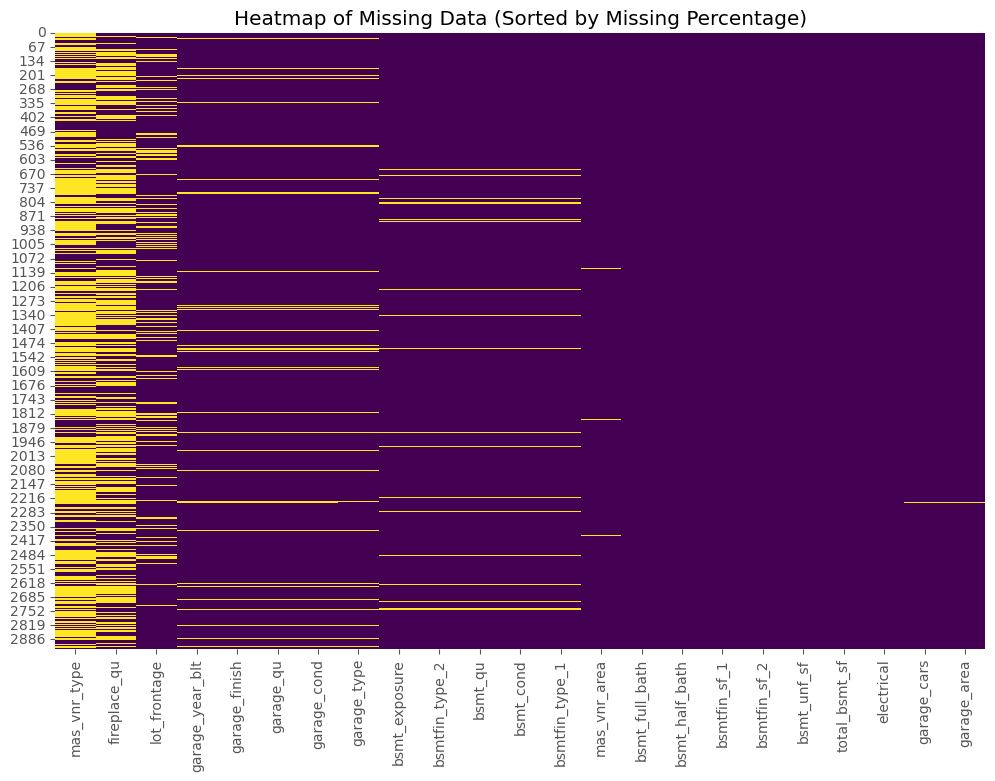

In [18]:
# Call the function to plot the heatmap
plot_missing_data_heatmap(df)

## Basement, Fireplace

Firstly, from the data dictionary, we know that 'NA' would imply No Pools! In fact, we can check this with the pool area.  

In the dataset, missing values for variables such as `bsmt` (basement-related features) are represented by `NA`, indicating the absence of a basement. Similarly for fireplace. We then fill categorical variables with `NONE` and numerical variables with 0 based on key words.

In [19]:
df = simple_fill_missing_by_keywords(df, ['bsmt', 'fireplace'])

### Electrical

There is only one missing value for electrical. 

In [20]:
df[df['electrical'].isnull()][['ms_subclass', 'neighborhood', 'year_blt']]

,ms_subclass,neighborhood,year_blt
1577,80,Timber,2006


In [21]:
# Check for the type similar properties in the area as they tend to have the same electrical type
df_original[(df_original['ms_subclass'] == 80) & (df_original['neighborhood'] == "Timber")].groupby(['year_blt'])['electrical'].value_counts()

year_blt  electrical
1987      SBrkr         1
1988      SBrkr         1
2003      SBrkr         1
2006      SBrkr         1
Name: count, dtype: int64

All the buildings in  `ms_subclass` (building class) and this Timber neighborhood all have `SBrkr` (Standard Circuit Breakers & Romex) as the electrical type. Therefore, it is reasonable to impute this missing value with SBrkr. 

In [22]:
# Fill missing electrical value with SBrkr based on similar properties in the area
df['electrical'] = df['electrical'].fillna('SBrkr')

### Garage

The column `garage_type` denotes 'No Garage' rather than 'NA' as when there is no garage but there are also NAs, and also the dictionary indicates that 'NA' for `garage_year_blt` can indicate missing garages. Here, we take a closer look at the garage type and area. 

In [23]:
consistency_missing_type_area(df, 'garage_area', 'garage_type')

{'percent_missing_area_zero': 100.0,
 'percent_missing_area_missing': 0.0,
 'percent_missing_area_other': 0.0}

In fact all the missing garage_type also have area zero so it means no garage. 

In [24]:
# Get missing garage info
garage_cols = df.columns[df.columns.str.contains('garage')]
missing_mask = df['garage_year_blt'].isnull()
missing = df.loc[missing_mask, garage_cols]
# Only either detached or no garage types for columns with missing year built. 
missing['garage_type'].value_counts(dropna=False), missing[missing['garage_type']=='Detchd'].head(2)

(garage_type
 NaN       157
 Detchd      2
 Name: count, dtype: int64,
      garage_type  garage_year_blt garage_finish  garage_cars  garage_area  \
 1356      Detchd              NaN           NaN          1.0        360.0   
 2236      Detchd              NaN           NaN          NaN          NaN   
 
      garage_qu garage_cond  
 1356       NaN         NaN  
 2236       NaN         NaN  )

In [25]:
# Only one observation where area is missing also.
df[df['garage_area'].isnull()][garage_cols]

,garage_type,garage_year_blt,garage_finish,garage_cars,garage_area,garage_qu,garage_cond
2236,Detchd,NaN,NaN,NaN,NaN,NaN,NaN


Although the majority of missing values for areas and year built indeed stem from garage type being recorded as 'No Garage' to begin with. As we denote the lack of a facility as `NA` (non-applicable) in such cases, we may want to standarise this notations. 

This indicates some inconsistencies in the data recording. Although the garage type is Detached, no built years are recorded. One observation clearly has a garage area, while the later lacks everthing. In this case, we may fill in the `garage_year_blt` with the year built of the property. For where garage_area is missing, we will fill in with 0. For all the other finish, condition and quality columns, we may just keep 'NONE' category (noting that this denotes either missing or not applicable), given that the non-easily-fillable missing values are too small to introduce another category

Now, check for inconsistencies in the year built and year sold if any houses are sold before they are built or fully remodelled. Furthermore, we check if any values are out of the range of the dataset 2006-2010. 

In [26]:
report_inconsistent_years(df, ['year_blt','year_remod/add' ,'garage_year_blt'], 'year_sold')

,year_blt,year_remod/add,garage_year_blt,year_sold
1702,2007,2008,2007.0,2007
2260,2006,2007,2207.0,2007


There is one observation that is built and one that is remodeled after it is sold. Additionally, there seems to be a typo for index 2260 in its `garage_year_blt`. However, it seems like the garage was build with remodelled and it was a typo from 2007 to 2207. There is one observation where it is sold before it is built and one before it is remodelled. Likely an outlier, that can be sold under very different conditions so we will drop this obseration

In [27]:
# Apply the imputer
df = garage_imputer(df)

In [28]:
# Check and print any cases where year_sold is less than year_blt or year_remod/add
inconsistent_years = df[df['year_sold'] < df['year_blt']]
if not inconsistent_years.empty:
    print("\nFound houses sold before they were built:")
    print(inconsistent_years[['year_sold', 'year_blt', 'year_remod/add']])
    
    inconsistent_remod = df[df['year_sold'] < df['year_remod/add']]
    if not inconsistent_remod.empty:
        print("\nFound houses sold before remodeling:")
        print(inconsistent_remod[['year_sold', 'year_blt', 'year_remod/add']])
    
    # Remove inconsistent years
df = df[~(df['year_sold'] < df['year_blt'])]
df = df[df['year_sold'] >= df['year_remod/add']]

### Masonry veneer type and area

In [29]:
# Call the function and print the results for 'mas_vnr_area' and 'mas_vnr_type'
consistency_missing_type_area(df, 'mas_vnr_area', 'mas_vnr_type')

{'percent_missing_area_zero': 98.30795262267344,
 'percent_missing_area_missing': 1.2972363226170334,
 'percent_missing_area_other': 0.39481105470953193}

In [30]:
# Check for inconsistencies in masonry veneer data
print("\nBreakdown of mas_vnr_area values where mas_vnr_type is missing:")
df[df['mas_vnr_type'].isnull()]['mas_vnr_area'].value_counts().sort_index()


Breakdown of mas_vnr_area values where mas_vnr_type is missing:


mas_vnr_area
0.0      1743
1.0         3
285.0       1
288.0       1
312.0       1
344.0       1
Name: count, dtype: int64

In [31]:
# Show rows where mas_vnr_area is missing
df[df['mas_vnr_area'].isnull()][['mas_vnr_area', 'mas_vnr_type']]

,mas_vnr_area,mas_vnr_type
55,NaN,NaN
484,NaN,NaN
517,NaN,NaN
538,NaN,NaN
867,NaN,NaN
1095,NaN,NaN
1119,NaN,NaN
1122,NaN,NaN
1127,NaN,NaN
1184,NaN,NaN


All of where `mas_vnr_type` are missing, we observe that its area is 0. We will then impute all the missing `mas_vnr_type` with `NONE` and `mas_vnr_area` with 0. This can be done by simply adding 'mas_vnr' to the keywords when calling ``simple_fill_missing_by_keywords()``

In [32]:
df = simple_fill_missing_by_keywords(df, ['mas_vnr'])

### Lot Frontage

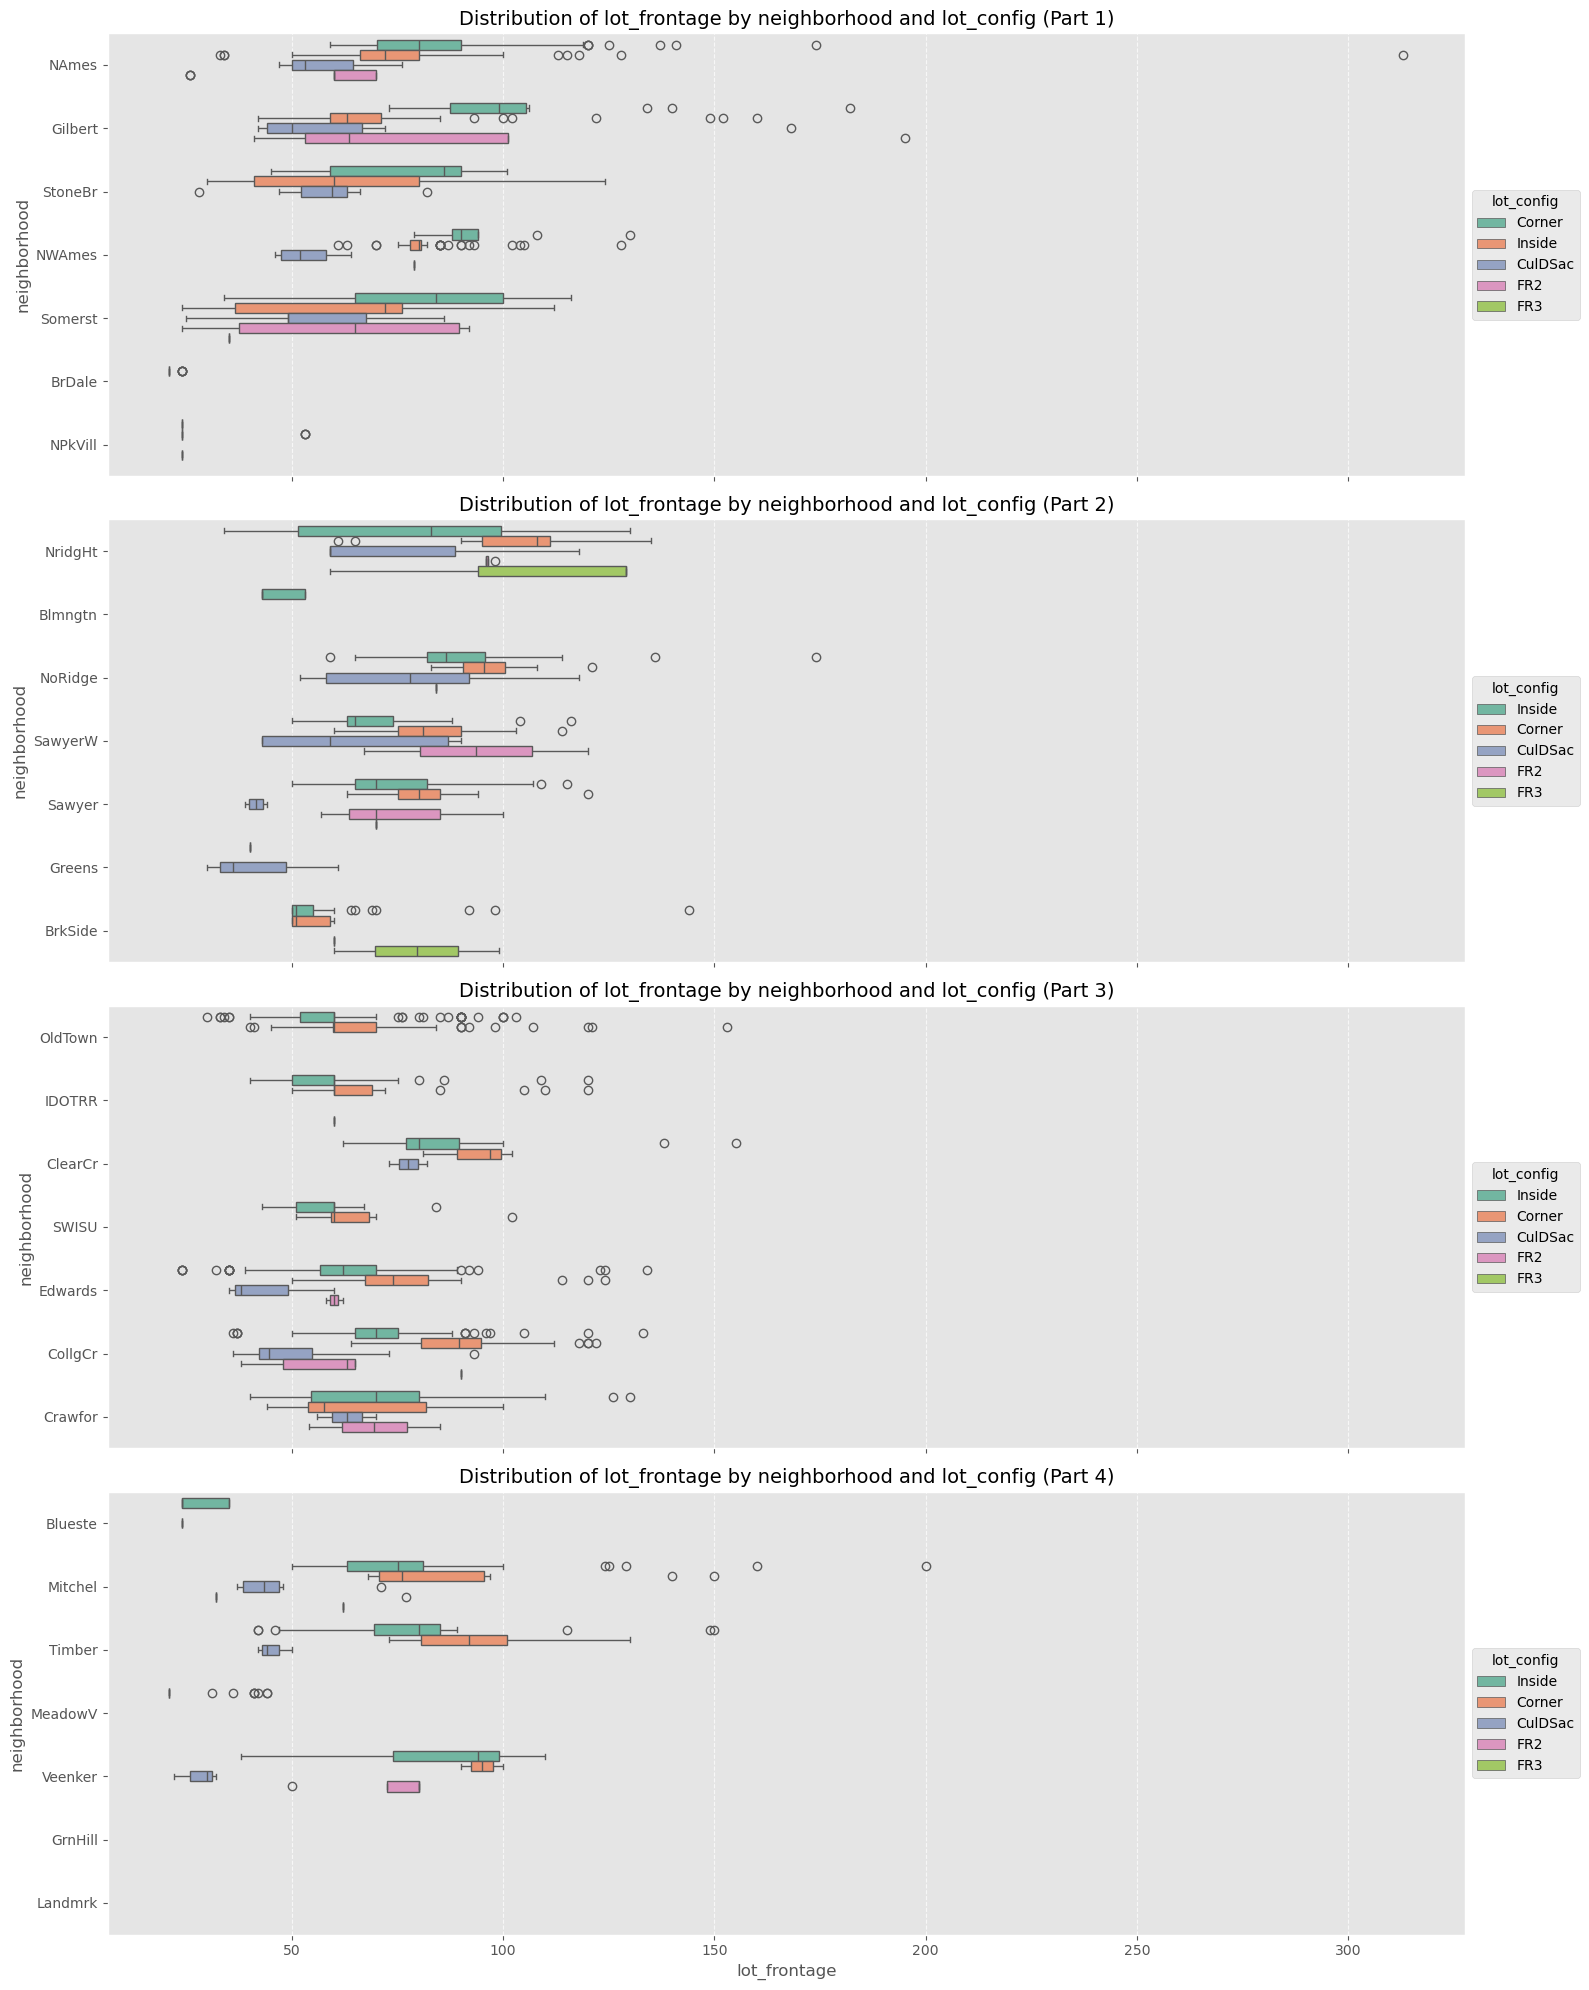

In [33]:
# Example usage
box_plot_dist(df, x='lot_frontage', y='neighborhood', hue='lot_config')

This shows that although there are some outliers, distribution of `lot_frontage` is very concentrated conditioned on `lot_config` (the configuration of the lot) and `neighborhood` that the discrepancy are within 100 feet. We will then impute the missing values with the median of the `lot_frontage` of observations with the same `neighborhood` and `lot_config`. This imputer will better incorporated into the pipeline to avoid data leakage (i.e. only imputing for each train/test set separately).

Before proceeding to the next step, we will format the data types for consistency.

#4. Feature Distribution

In [34]:
plot_feature_distributions_interactive(df,
    [col for col in df.columns if col in nominal and col != 'saleprice'],
    [col for col in df.columns if col in ordinal and col != 'saleprice'],
    [col for col in df.columns if col in continuous and col != 'saleprice'], 
    [col for col in df.columns if col in discrete and col != 'saleprice'])

Exiting the interactive plotting.


Feel free to select what you want to see. Give it 2-3 secs.

1. Most categorical features exhibit strong class imbalance, with one or two dominant categories.

2. For continuous features, measurements related to property size (`lot_frontage`, `lot_area`) and living spaces (room areas, garage areas) show right-skewed distributions with heavy tails. Other continuous variables tend to have a high concentration of zeros with extended right tails.

3. For discrete features, we observe several notable patterns:
   a. The distributions of `garage_year_blt` and `year_blt` are remarkably similar, even though we only imputed the built year for garage for 153 observations only. 
   
   b. The distributions of full and half bathrooms show strong correlation. Maybe we can also consider the percentage of half bath and full bath as to the distribution of the total number of baths in the house. This can provide information about the building's capacity for full/half baths rather than just the number of different types. For example, a house with 2 full baths and 2 half baths (50% full, 50% half) is quite different in utility from one with 3 full baths and 1 half bath (75% full, 25% half).

   c. Given the narrow time window of sales (2006-2010), calculating building age at sale may not add significant value as that does not differ significantly from the information on year built. However, we can add a feature of the year difference between built and remodelled relative to the year built and sold. This will clearly be scaled between 0 and 1; with 0 indicating the building never gets remodelled and 1 indicating the building is remodelled very recently. Hence, this can show the relative timing of the remodelling relative to the life-span of the building till it gets sold. 

   d. Apart from features related to years, all other features maybe considered as ordinal categories, all maybe have a monotonic relationship with the sale price that the more rooms and facilities, the better.

4. We have many constant features that are not useful for prediction. We can drop them. 

Let's take a closer look at the sparsity of the categorical features. 

In [35]:
# Drop features that are mostly constant
little_var_features = ['functional', 'bsmtfin_type_2', 'utilities', 'street', 'condition_2', 'roof_matl', 'low_qu_fin_sf', 'bsmtfin_sf_2', 'kitchen_abvgr']
df = df.drop(columns=little_var_features)


In [36]:
# Analyze categorical features
cat_analysis = analyze_categorical_sparsity(df, threshold_dominant=0.90, threshold_rare=0.02)
cat_analysis

,Feature,Unique Values,Most Common,Most Common %,Least Common,Least Common %,Has Dominant,Rare Categories
0,heating,6,GasA,98.461012,Floor,0.034200,True,5
1,electrical,5,SBrkr,91.552668,Mix,0.034200,True,3
2,garage_cond,6,TA,90.937073,Ex,0.102599,True,3
3,land_slope,3,Gtl,95.177839,Sev,0.547196,True,1
4,central_air,2,Y,93.296854,N,6.703146,True,0
5,paved_drive,3,Y,90.492476,P,2.120383,True,0
6,neighborhood,28,NAmes,15.150479,Landmrk,0.034200,False,12
7,exterior_2nd,17,VinylSd,34.678523,Other,0.034200,False,10
8,exterior_1st,16,VinylSd,35.054720,ImStucc,0.034200,False,9
9,sale_type,10,WD,86.662107,VWD,0.034200,False,7


1. The dataset contains categorical features with varying levels of dominance. For example, **heating** and **electrical** have strong dominant categories (GasA: 98.46% and SBrkr: 91.55%, respectively), while others like **neighborhood** are more evenly distributed across categories.

2. Features like **central_air** and **paved_drive** have binary or simple options with high dominance (93.30% and 90.49% for "Y"), suggesting limited variation in these attributes, which might influence their predictive power in models.

3. Rare categories (e.g., **Landmrk** in neighborhood, **Floor** in heating) appear sporadically across features, and while they can add detail, they might require special treatment (e.g., combining rare levels) during analysis or model training to avoid overfitting or instability.

#5. Features' Correlation with Target

Feel free to select what you want to see. Give it 2-3 secs.

In [37]:
plot_feature_target_relationships_interactive(df,
    [col for col in df.columns if col in nominal and col != 'saleprice'],
    [col for col in df.columns if col in ordinal and col != 'saleprice'],
    [col for col in df.columns if col in continuous and col != 'saleprice'], 
    [col for col in df.columns if col in discrete and col != 'saleprice'],
    target_col='saleprice')

Exiting the interactive plotting.


#### For categorical features

1. **Neighborhood**: Strongly impacts sale prices, with areas like `NoRidge` and `StoneBr` showing significantly higher medians.  
2. **Garage Type**: `BuiltIn` garages correlate with higher sale prices, while `Detchd` types are lower.  
3. **Central Air**: We may consider dropping Central Air as very few houses have no central air.
4. **Year Built**: Newer homes (2006-2010) consistently show higher prices, emphasizing the importance of home age.  
5. **Seasonality**: Sale prices peak in warmer months (May-July), highlighting seasonal trends in housing demand.  

#### For Ordinal features

1. **Lot Shape (`lot_shape`)**:  
   - Categories like `IR2` and `IR3` have very few data points, potentially causing instability in analysis.  
   - Suggest regrouping `IR2` and `IR3` into a single "Irregular" category.

2. **Land Slope (`land_slope`)**:  
   - `Mod` has significantly fewer observations compared to `Gtl`, indicating an imbalance and little useful variations. Hence we may consider drop it.
   - Given the geographic of Iowa, in fact, outliers house would have moderately sloping land.

3. **Bsmt**: `bsmt_exposure`, `bsmt_qu`, `bsmt_cond`, the bottom (No categories) should be merged with the less good ones (this is quite intuitive indeed for how people would enjoy their basement. A bad one is still better than no basement!).

4. **Heating Quality (`heating_qu`)**:  
   - Only two categories (`Ex` and `Gd`) are present. Excellent heating is better than good heating but also greater variance in the average price. 

5. All other features of quality also seems good and there is no obvious outliers. 

#### For Continuous Features
Features with too few variations, leading to weak correlations or minimal impact on sale price, should be dropped:

1. **Open_porch_sf** (Correlation: 0.036) - Very weak relationship with minimal variation.
2. **Enclosed_porch** (Correlation: 0.148) - Shows limited variation and weak predictive value.
3. **3ssn_porch** (Correlation: 0.126) - Sparse data points and negligible correlation.
4. **pool_area** very sparse.

Overall, only max five houses, have porches out of two thousands have porches, and therefore we can drop them. 

#### For Discrete Features

1. **Bsmt_half_bath** (Correlation: 0.115) – Limited variation and low correlation. Can drop as only 1 house has positive half-bath in the basement.
2. **Garage_cars** For Garage Area in terms of car capacity, may consider grouping the bottom two (similar to the argument on quality, a too small garage may be of little use to no garage at all)

#### For Discrete Features

1. **Bsmt_half_bath** (Correlation: 0.115) – Limited variation and low correlation. We can drop as only 1 house has positive half-bath in the basement.
2. **Garage_cars** For Garage Area in terms of car capacity, may consider grouping the bottom two (similar to the argument on quality, a too small garage may be of little use to no garage at all)

In [38]:
# Drop columns with 'porch', 'bsmt_half_bath', and 'land_slope', 'pool_area'
df = df.drop(columns=['open_porch_sf', 'enclosed_porch', '3ssn_porch', 'screen_porch', 'bsmt_half_bath', 'land_slope'])

In [39]:
# Update feature lists to only include remaining columns in df
nominal = [col for col in nominal if col in df.columns]
ordinal = [col for col in ordinal if col in df.columns] 
continuous = [col for col in continuous if col in df.columns]
discrete = [col for col in discrete if col in df.columns]


# 6. Closer look at categorical features

**ANOVA (Analysis of Variance)** is a statistical method used to assess the influence of categorical features on a continuous target variable by comparing the means of different groups.
1. Perform one-way ANOVA on each categorical feature to determine its effect on the target variable. This involves calculating the F-statistic, which is the ratio of the variance between group means to the variance within the groups.
2. Calculate the effect size (eta squared, η²) for each feature to quantify its impact. The formula for eta squared is η² = SS_between / SS_total, where SS_between is the sum of squares between groups and SS_total is the total sum of squares.
3. Identify and rank the top categorical features with the largest effect sizes for further analysis, focusing on those with the highest η² values.


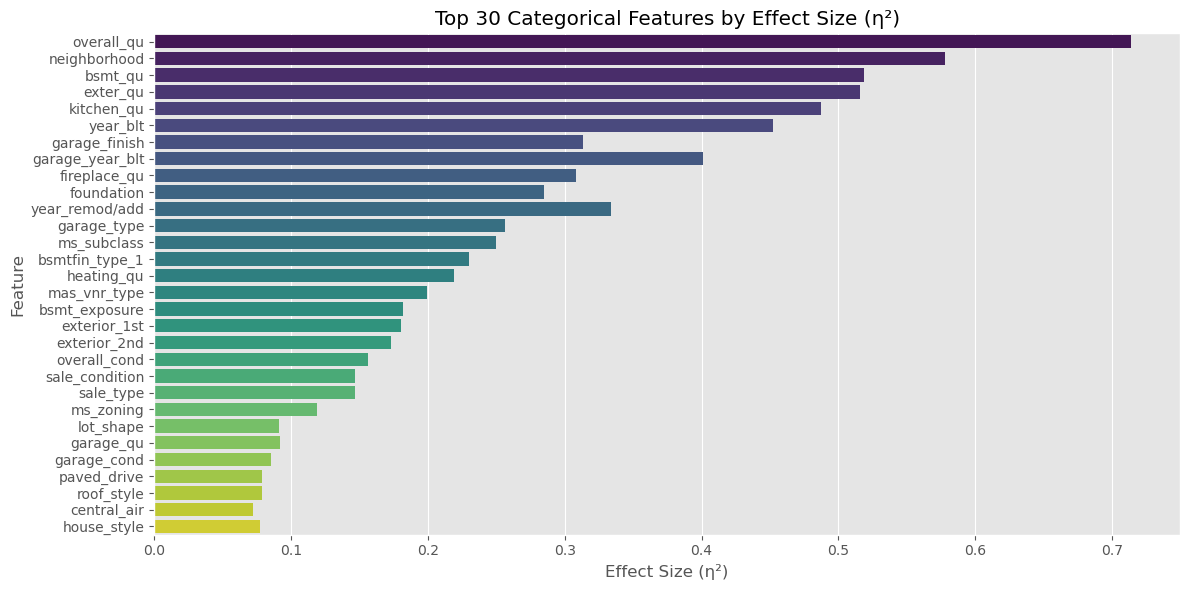

In [40]:
# Filter for features with effect size > 0.1
anova_categorical_feature_importance(df, nominal + ordinal, top_n=30)

The results appear to make sense, as key features like **"overall_qu"** and **"bsmt_qu"** (quality overall and of the basement) are highly influential. 

Features like **"neighborhood"** and **"kitchen_qu"** are also prominent.

In [41]:
# Keep only specified categorical variables
categorical_vars_to_keep = [
    'ms_zoning', 'sale_type', 'sale_condition', 'overall_cond',
    'exterior_2nd', 'exterior_1st', 'bsmt_exposure', 'mas_vnr_type',
    'heating_qu', 'bsmtfin_type_1', 'ms_subclass', 'garage_type',
    'year_remod/add', 'foundation', 'fireplace_qu', 'garage_year_blt',
    'garage_finish', 'year_blt', 'kitchen_qu', 'exter_qu', 'bsmt_qu',
    'neighborhood', 'overall_qu', 'mo_sold', 'year_sold'
]
# Here also kept year_sold and mo_sold as they are very useful for the seasonality patterns
# Keep only specified categorical columns plus continuous/discrete features and target
df = df[categorical_vars_to_keep + continuous + discrete + ['saleprice']]


Cramér's V is a measure of association between two nominal variables, giving a value between 0 and 1.
It is based on the chi-squared statistic and provides insight into the strength of the relationship between categorical features.
The formula for Cramér's V is:
V = sqrt(χ² / (n * (k - 1)))
where:
- χ² is the chi-squared statistic,
- n is the total number of observations,
- k is the minimum number of categories in either variable.

In the function `plot_cramer_v_associations`, we calculate Cramér's V for each pair of categorical features.
We first generate all possible pairs of categorical features and then compute the chi-squared statistic for each pair.
Using the chi-squared statistic, we calculate Cramér's V to measure the strength of association.
Finally, we plot the top 30 pairs with the highest Cramér's V values to visualize the strongest associations.

This measure helps identify pairs of categorical features that are strongly associated, which can be useful for feature engineering and reducing redundancy in the dataset.


In [42]:
# Update feature lists to only include remaining columns in df
nominal = [col for col in nominal if col in df.columns]
ordinal = [col for col in ordinal if col in df.columns] 
continuous = [col for col in continuous if col in df.columns]
discrete = [col for col in discrete if col in df.columns]

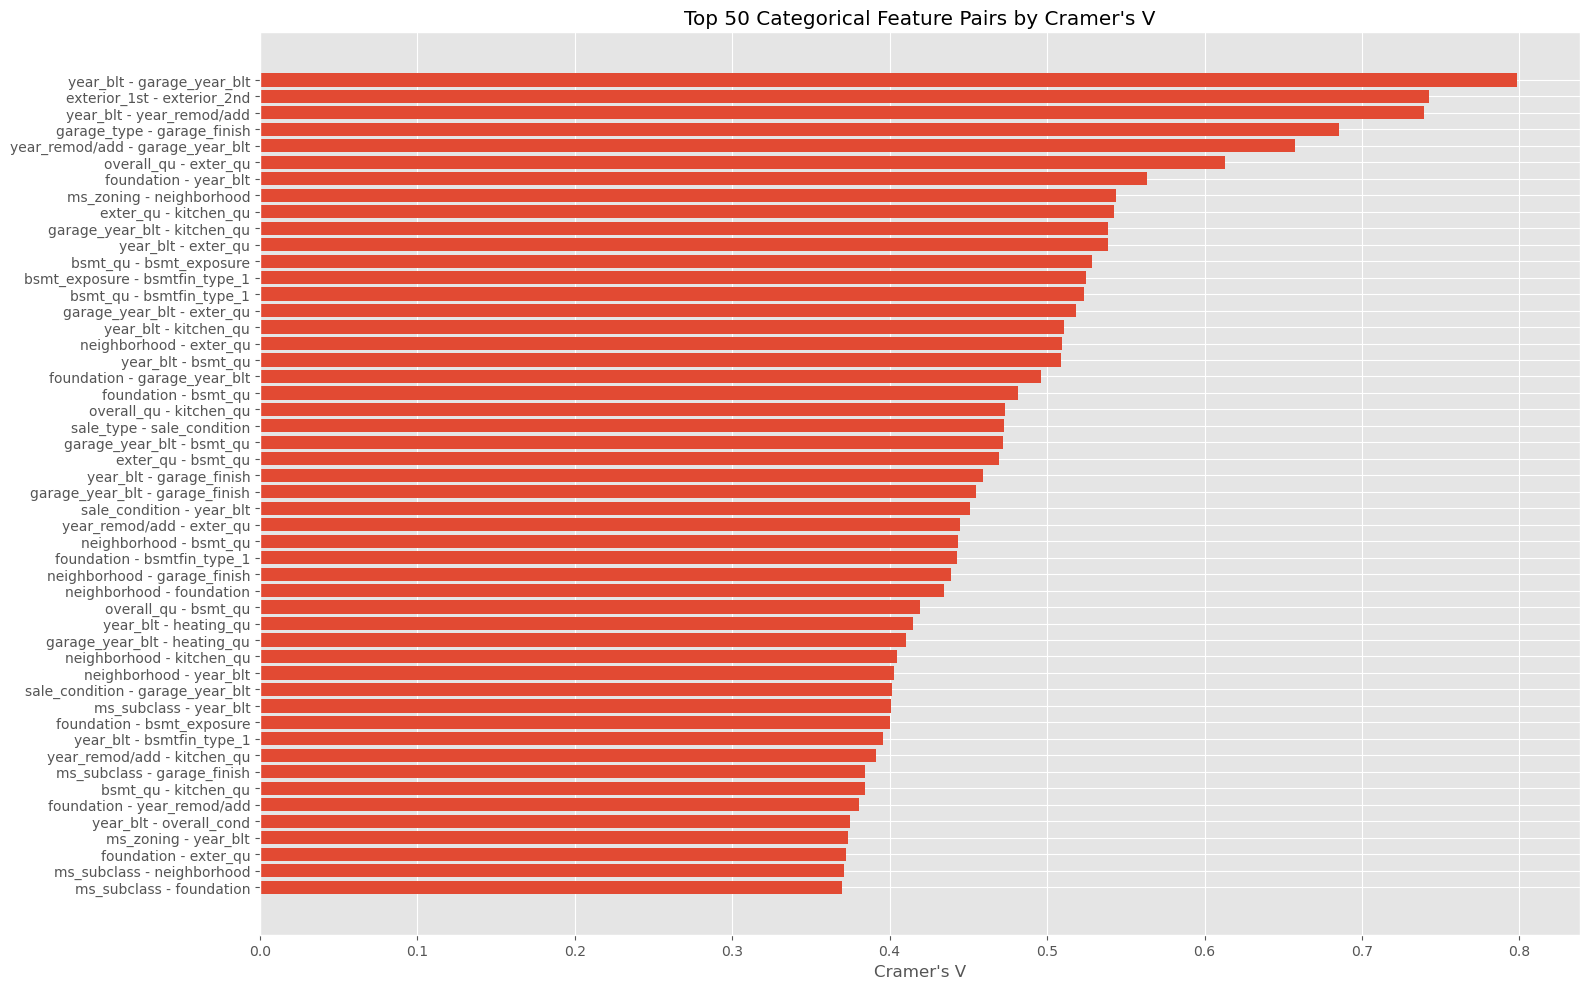

In [43]:
# Call function with combined categorical features
plot_cramer_v_associations(df, nominal + ordinal, top_n=50)

We see that `year_blt` and `garage_year_blt` will be redundant, and clearly most `exterior_2nd` materials coincide with `exterior_1st`. The `year_remod/add` also does not add much information as it is closely related to `year_blt`. `garage_type` (where it is built) and `garage_finish` (level of interior finish) will also be likely correlated. Clearly, `bsmtfin_type_1` and `bsmt_qu` will be highly correlated as they both indicate the level of finishing of the basement, and hence `bsmtfin_type_1` will closely correlate with the basement quality (`bsmt_qu`).

Let's take a closer look at `neighbourhood` and `mszoning`. 

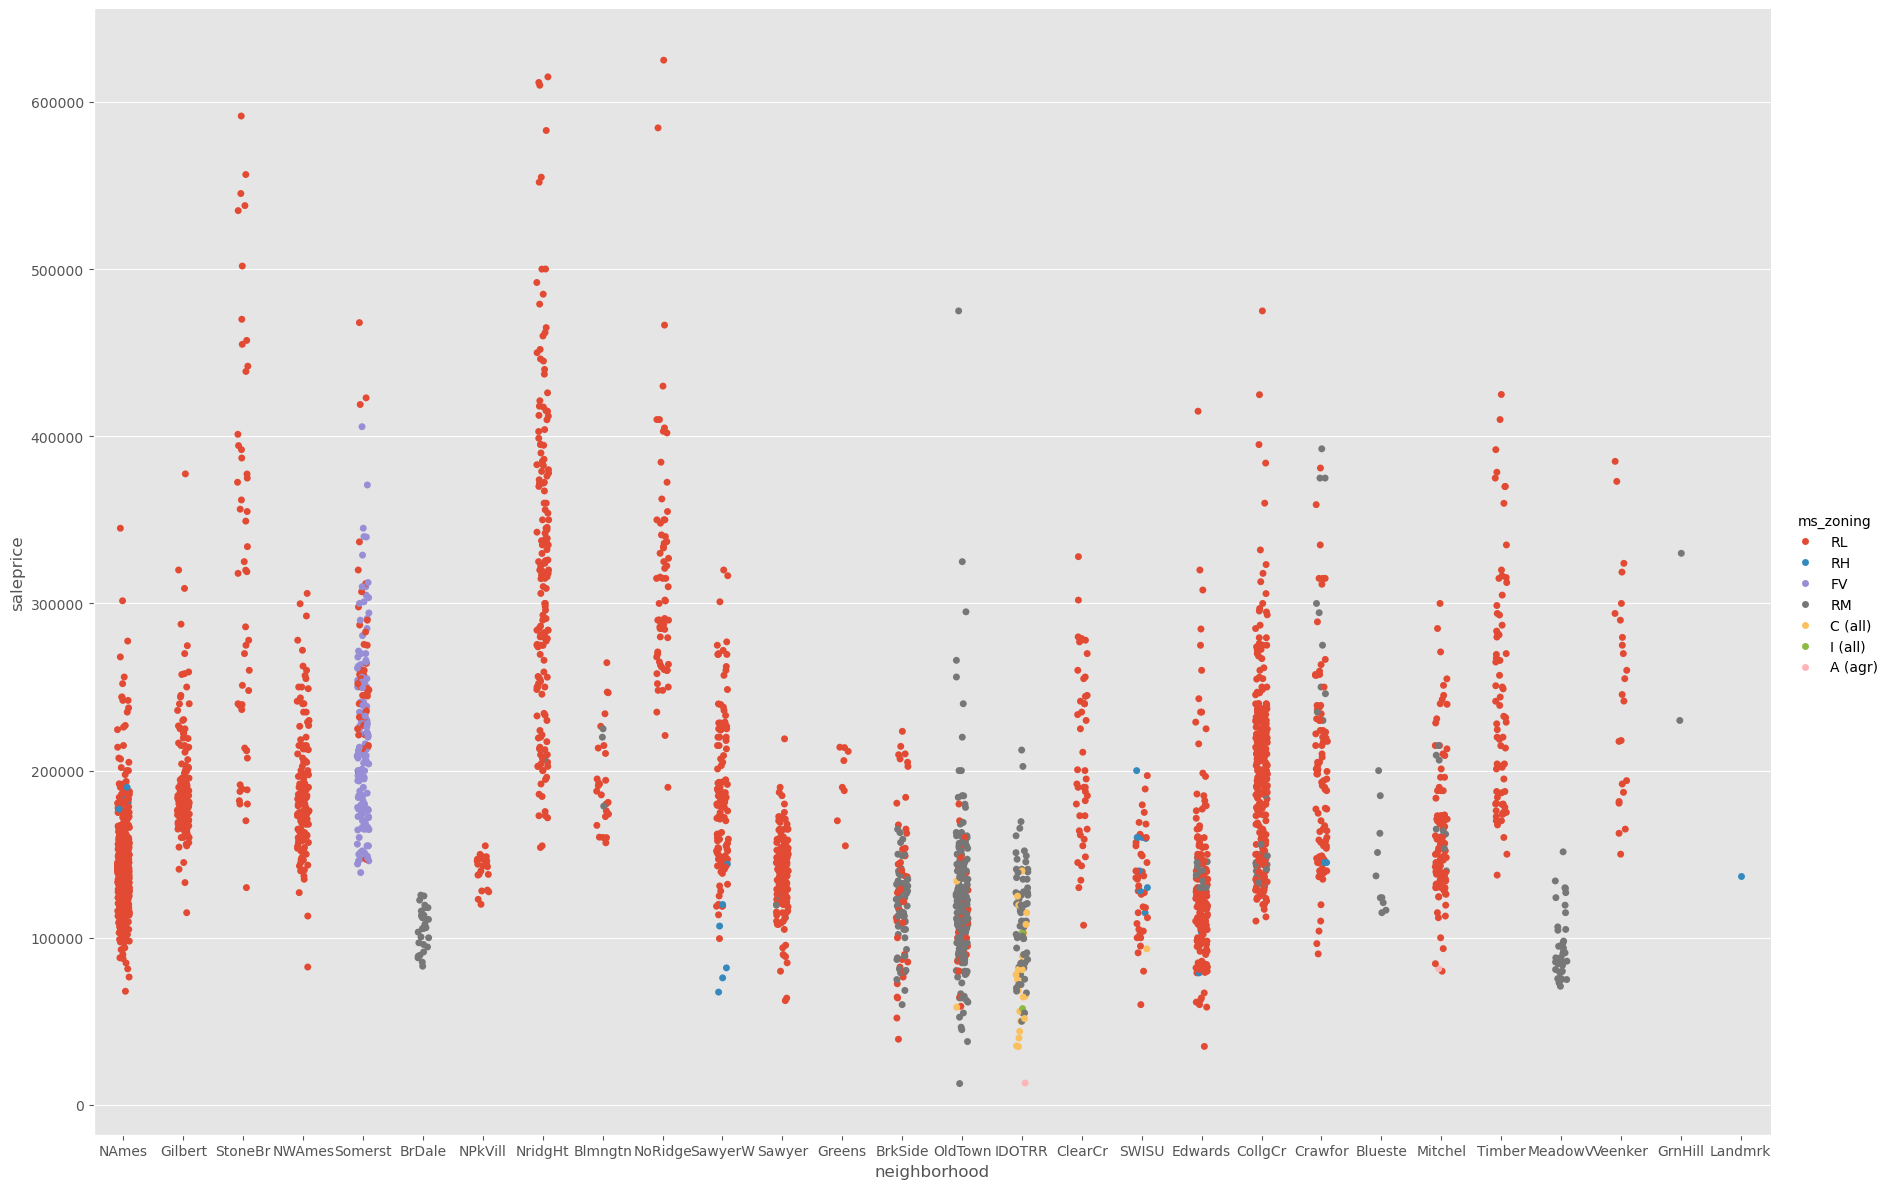

In [44]:
# Swarming Catplot FTW
fig = sns.catplot(x='neighborhood', y='saleprice', hue='ms_zoning', data=df, kind='strip', height=12, aspect=1.5)
ax = fig.axes[0][0]
plt.show()

In [45]:
# Drop features based on correlation analysis
# garage_year_blt - highly correlated with year_blt
# exterior_2nd - highly redundant with exterior_1st materials
# year_remod_add - closely related to year_blt
# garage_type and garage_finish - correlated as they both describe garage characteristics
# bsmtfin_type_1 - highly correlated with bsmt_qu (basement quality)
# ms_subclass - corresponds to foundation type, redundant
# ms_zoning - shows high correlation with neighborhood
# bldg_type - correlates with house_style
# garage_type - correlates with garage characteristics
# house_style - redundant with other structural features
# sale_condition - collinear with sale_type as different transactions involve different methods
df = df.drop(['garage_year_blt', 'exterior_2nd', 'year_remod/add', 
              'garage_type', 'garage_finish', 'bsmtfin_type_1',
              'ms_subclass', 'ms_zoning', 'sale_condition'], axis=1)

# 7. Closer look at numerical features

In [46]:
# Update feature lists to only include remaining columns in df
nominal = [col for col in nominal if col in df.columns]
ordinal = [col for col in ordinal if col in df.columns] 
continuous = [col for col in continuous if col in df.columns]
discrete = [col for col in discrete if col in df.columns]

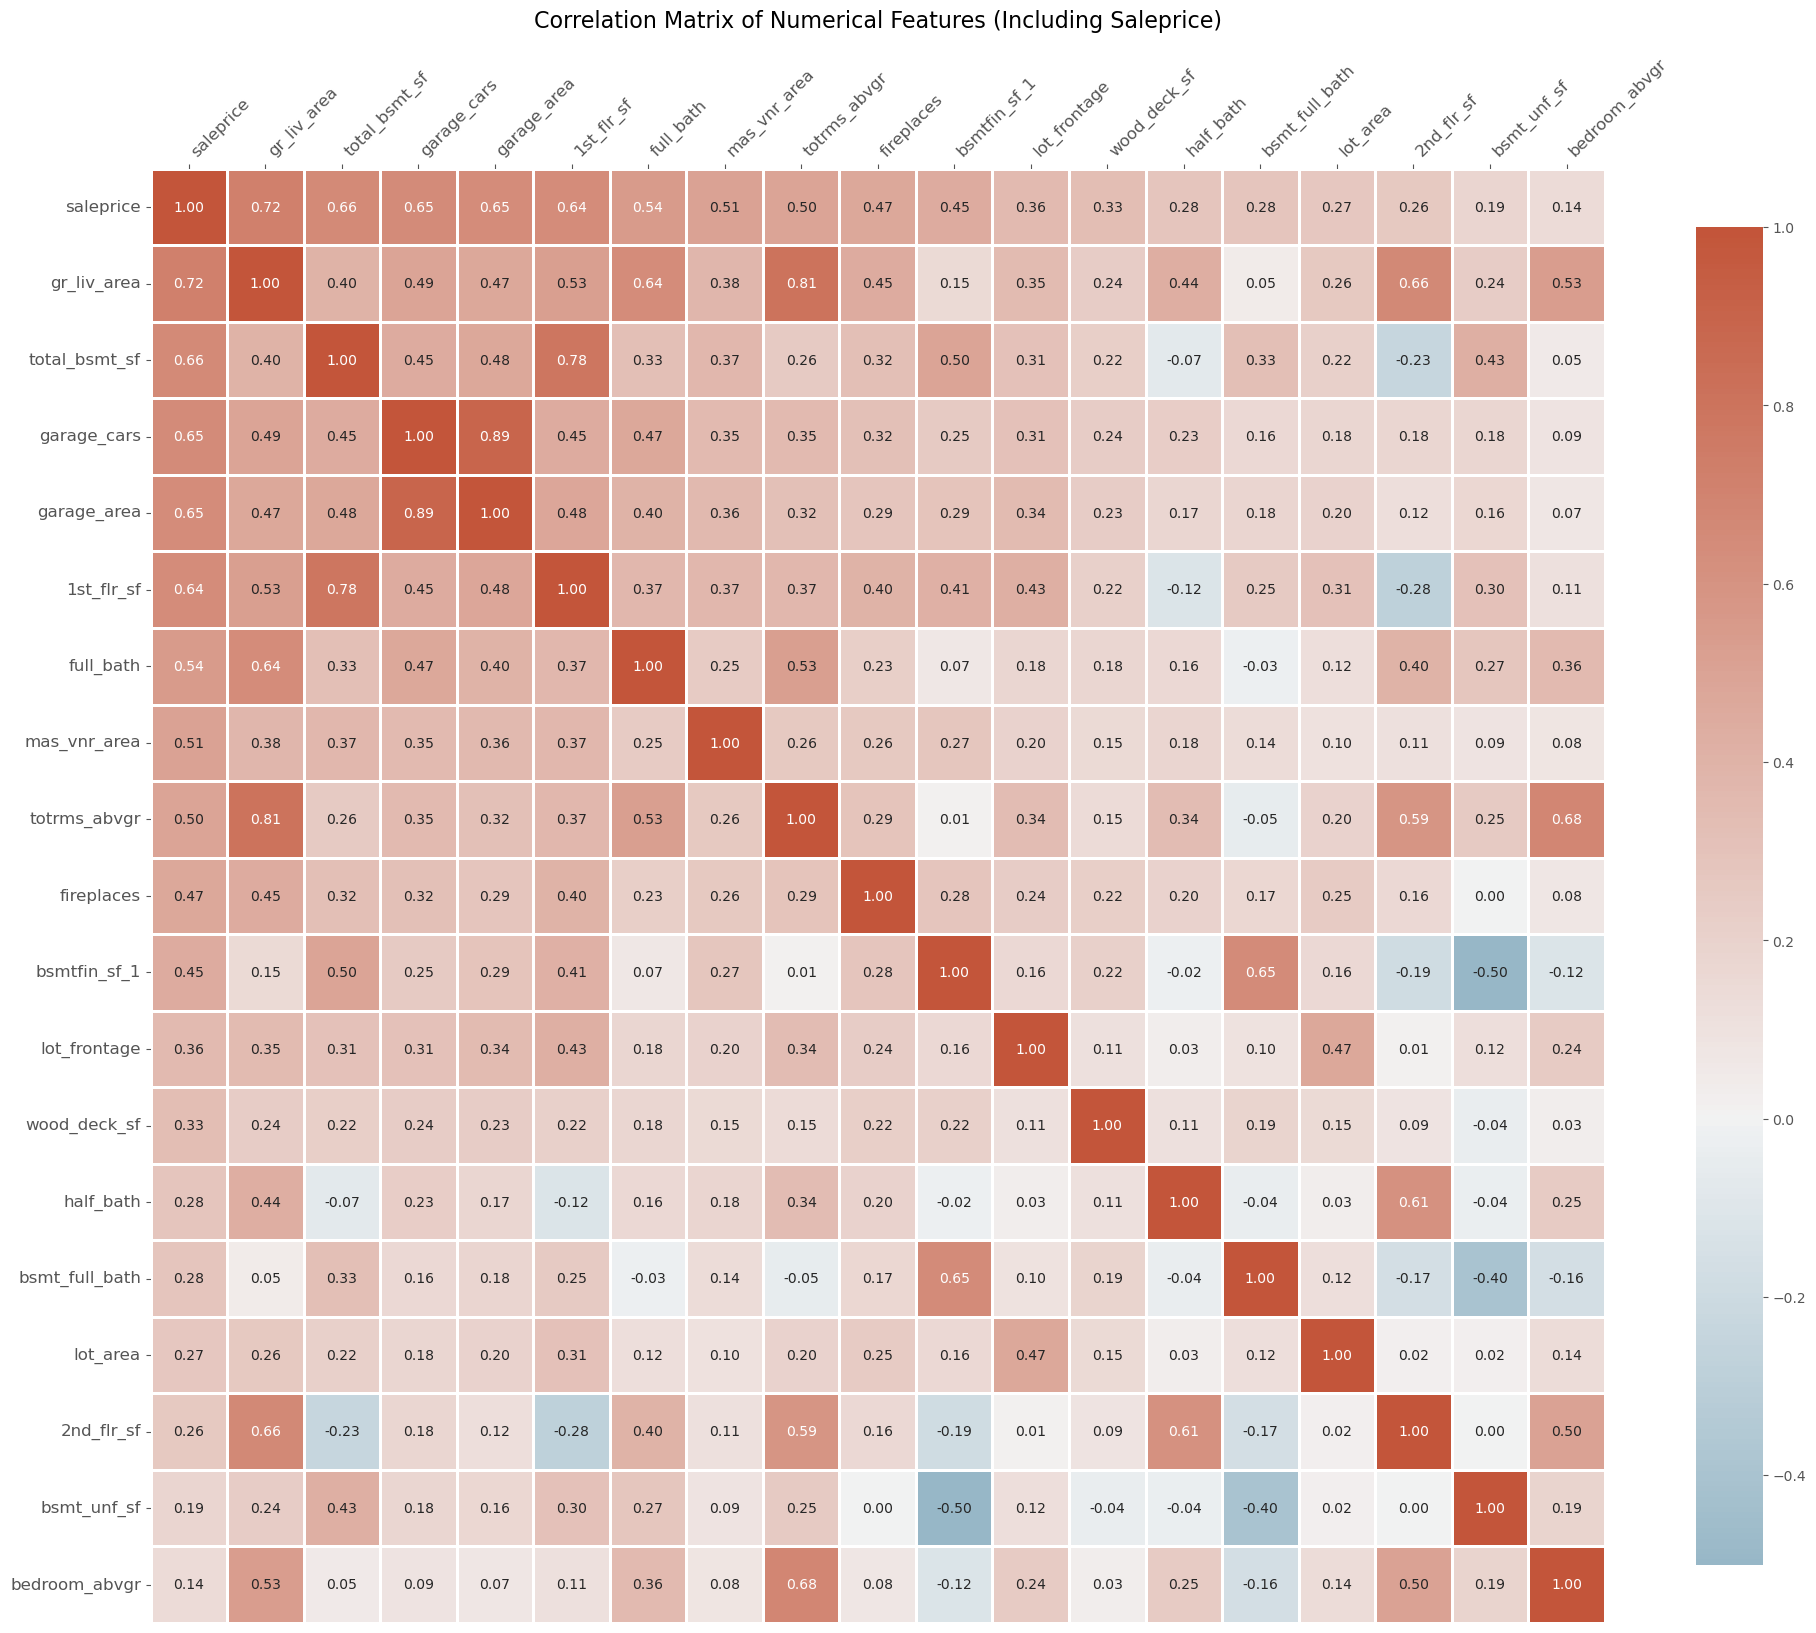

In [47]:
plot_numerical_correlation_matrix(df, target='saleprice', numerical_cols=continuous + discrete)

##### VERY STRONG CORRELATION !!!
1. **`garage_cars`** and **`garage_area`** (0.82): Both capture information about garage capacity. Since they measure the same thing in different units, we can drop one.
2. **`total_bsmt_sf`** and **`1st_flr_sf`** (0.98): These are almost perfectly correlated since the first floor typically sits directly on top of the basement foundation.
3. **`gr_liv_area`** and **`totrms_abvgrd`** (0.80): Total above-ground living area strongly predicts number of rooms, as expected.
4. **`bsmtfin_sf_1`** and **`bsmt_full_bath`** (0.86): Strong correlation between finished basement area and presence of full bathrooms, as bathrooms are typically added during basement finishing.
5. **`bsmtfin_sf_1`** and **`bsmt_unf_sf`** (-0.71): Strong negative correlation since these represent complementary portions of total basement area - as finished area increases, unfinished must decrease.

In [48]:
# Drop highly correlated features
df = df.drop(['garage_cars', '1st_flr_sf', 'totrms_abvgr', 'bsmt_full_bath', 'bsmtfin_sf_1'], axis=1)

# 8. Summary of Cleaning and Formatting Steps

**Steps- Data Cleaning**

1. **Reformat Column Names**  - implicitly done in the `preliminary_loader`
   - **Objective:** Clean column names for consistency.
   - **Action:**  
     - Remove spaces from column names.
     - Convert all column names to lowercase.
     - Ensure consistent naming (e.g., no underscores, standard abbreviations).

2. **Outlier Removal**  
   - **Objective:** Remove rows with outliers.
   - **Action:**  
     - Drop rows where `gr_liv_area > 4000` and `saleprice < 200000`.

3. **Missing Values Imputation:**
   - **Objective:** Fill missing values based on predefined strategies.
   - **Actions:**  
     - **Keywords-Based Filling:** Use the function `simple_fill_missing_by_keywords()` to fill in missing values for the following columns using dictionary-based (and further exploration) information
     - **Electrical Column Imputation:** Fill missing values in the `electrical` column with `'SBrkr'` (based on common electrical type for similar properties in the area).
     - **Garage Information Imputation:** Use the `garage_imputer()` function to fill missing garage-related information.
     - **Motivating Lot Frontage Imputation in the pipeline after train/test split (not done here):** Fill missing `lot_frontage` values with the **median** value of properties that share the same `neighborhood` and `lot_config` (assuming similar lot characteristics across the neighborhood).

All this is done when you run the `integration_scipts/load_and_clean.py` directly from the terminal. It will give you a copy of the cleaned data in the `_cleanfile` folder (apart from imputing `lot_frontage`). 

# 9. Summary of EDA Insights on Features

Through this EDA, we managed to drop features that are unique to the very minority of houses, features that are redundant and highly correlated with each other, and features that are not useful for prediction given too little variations. After droppings, the remaining features are:

There are 30 features left, compared to the original 80. We primarily focused on  features that are not too common that every house would have (like most would have 1 kitchen etc.) but also too rare in all observations and hence are outliers, reducing the generalizability of the model (such as houses with tenis courts etc.)

We also develop a grouping strategy fo features with high class imbalance, like indicators on basement quality - the no basement and the not very good ones should be grouped together.

We also consider new features of dummies for the financial crisis impact, which is very interesting in fact. 

In [49]:
df = type_formatting(df, [
    'exter_qu',
    'bsmt_qu',
    'bsmt_exposure', 
    'heating_qu',
    'kitchen_qu',
    'fireplace_qu'
], ordinal_mappings)

You can obtain the clean data by running the `integration_scipts/load_and_clean.py` directly from the terminal. 

We will develop custom transformer for nomial categories to group features with more than two types and map a type that is irfrequent, while for ordinal categories, we will define a mapping that that if some types have too few observations, then we will do an accumulate grouping (i.e. with just the above) till we have enough observations for each. This helps to reduce the number of categories and also to reduce the class imbalance, while preserving the ranking information. 

For numerical features, they vary significantly in scale with some distinct values at tails. To reduce their impacts (while still trying to best incorporate these unique information that can help us better understand why some houses are sold for more), we will use a Yeo-Johnson Transformation and center/scale a vector

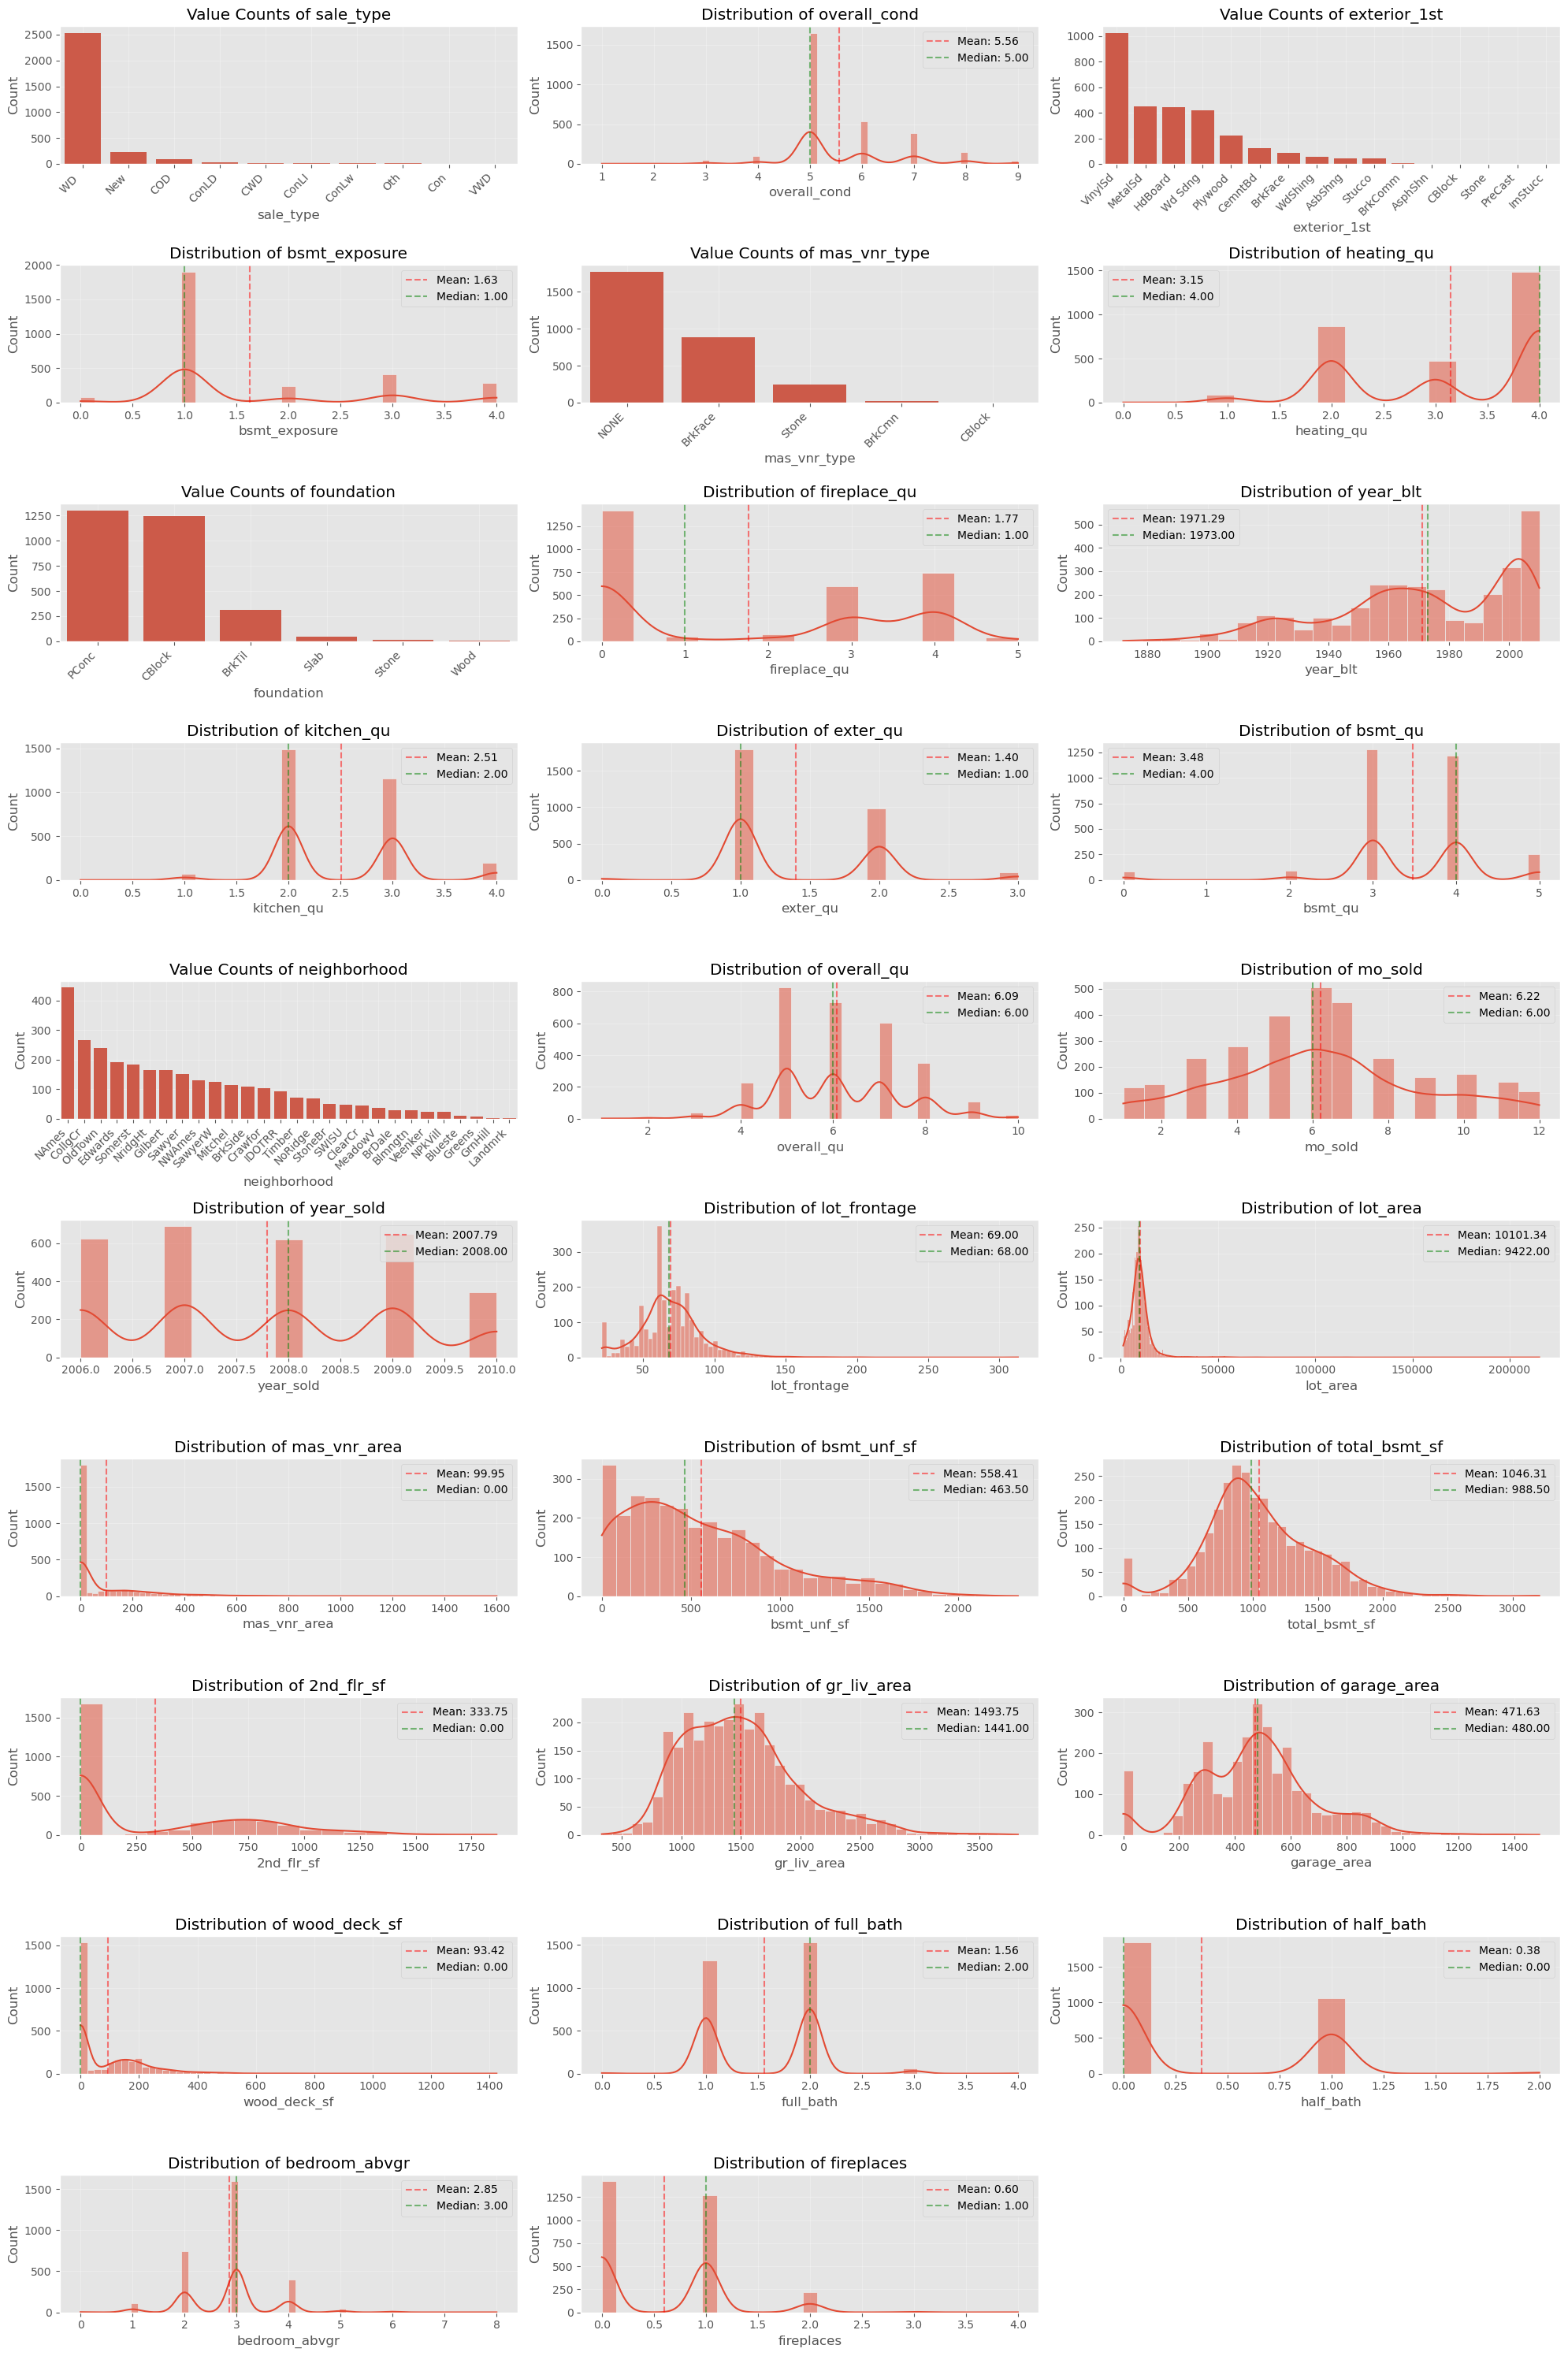

In [50]:
# Get remaining columns
remaining_cols = df.columns[~df.columns.isin(['order', 'pid', 'saleprice'])]

# Call the function with remaining columns
plot_feature_histograms(df, columns=remaining_cols)